In [1]:
#importando drive com imagens
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd
import seaborn as sns
import pathlib


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D # Updated import statements
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers
from keras import metrics

In [4]:
data_dir = pathlib.Path("/content/drive/MyDrive/TCC_DOCS/images")
print(data_dir)

/content/drive/MyDrive/TCC_DOCS/images


In [6]:
#tamanho de imagem
vgg16_img_size = 100
#número de exemplos que serão processados juntos em uma única iteração do modelo durante o treinamento
vgg16_batch_size = 150

vgg16_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    seed=123,
    image_size=(vgg16_img_size, vgg16_img_size),
    batch_size=vgg16_batch_size)

vgg16_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(vgg16_img_size,vgg16_img_size),
    batch_size=vgg16_batch_size)

vgg16_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    seed=123,
    image_size=(vgg16_img_size,vgg16_img_size),
    batch_size=vgg16_batch_size)

class_names = vgg16_test_ds.class_names

Found 47813 files belonging to 5 classes.
Found 47813 files belonging to 5 classes.
Using 9562 files for validation.
Found 47813 files belonging to 5 classes.


In [7]:
for image_batch, labels_batch in vgg16_train_ds:
  vgg16_train_img = image_batch
  vgg16_train_labels = labels_batch
  break
for image_batch, labels_batch in vgg16_val_ds:
  vgg16_val_img = image_batch
  vgg16_val_labels = labels_batch
  break
for image_batch, labels_batch in vgg16_test_ds:
  vgg16_test_img = image_batch
  vgg16_test_labels = labels_batch
  break

In [8]:
# ajusta automaticamente o número de threads para o pré-processamento dos dados. melhorar a performance e a eficiência do pipeline de dados.
AUTOTUNE = tf.data.experimental.AUTOTUNE

vgg16_train_ds = vgg16_train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
vgg16_val_ds = vgg16_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
vgg16_test_ds = vgg16_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
#aumentando a diversidade do conjunto de treinamento
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(vgg16_img_size,
                                                              vgg16_img_size,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

In [10]:
# VGG16
img_shape = (vgg16_img_size,vgg16_img_size,3)
VGG16_model = tf.keras.applications.VGG16(input_shape=img_shape,include_top=False,weights='imagenet')

58889256/58889256 [==============================] - 0s 0us/step


In [11]:
VGG16_model.trainable=False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(5,activation='relu',bias_regularizer=regularizers.l2(1e-4))

In [12]:
num_classes = 5
vgg16_model = Sequential([
    data_augmentation,
    VGG16_model,
    prediction_layer,
    global_average_layer,
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Activation('softmax'),
])

In [13]:
vgg16_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 100, 100, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 dense (Dense)               (None, 3, 3, 5)           2565      
                                                                 
 global_average_pooling2d (  (None, 5)                 0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 5)                 0         
                                                                 
 batch_normalization (Batch  (None, 5)                 20        
 Normalization)                                       

In [14]:
vgg16_model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [15]:
epochs = 50
history = vgg16_model.fit(
  vgg16_train_ds,
  validation_data=vgg16_val_ds,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


319/319 [==============================] - 2116s 262ms/step - loss: 1.2877 - accuracy: 0.5722 - val_loss: 0.8865 - val_accuracy: 0.7247
Epoch 2/50
319/319 [==============================] - 36s 113ms/step - loss: 0.9894 - accuracy: 0.7058 - val_loss: 0.8418 - val_accuracy: 0.7420
Epoch 3/50
319/319 [==============================] - 36s 112ms/step - loss: 0.8660 - accuracy: 0.7344 - val_loss: 0.7832 - val_accuracy: 0.7516
Epoch 4/50
319/319 [==============================] - 36s 112ms/step - loss: 0.7908 - accuracy: 0.7450 - val_loss: 0.7399 - val_accuracy: 0.7561
Epoch 5/50
319/319 [==============================] - 36s 112ms/step - loss: 0.7459 - accuracy: 0.7491 - val_loss: 0.7213 - val_accuracy: 0.7576
Epoch 6/50
319/319 [==============================] - 36s 112ms/step - loss: 0.7188 - accuracy: 0.7506 - val_loss: 0.6866 - val_accuracy: 0.7580
Epoch 7/50
319/319 [==============================] - 36s 112ms/step - loss: 0.6994 - accuracy: 0.7525 - val_loss: 0.6739 - val_accuracy: 0

In [16]:
vgg16_loss, vgg16_acc = vgg16_model.evaluate(vgg16_test_ds)

319/319 [==============================] - 227s 695ms/step - loss: 0.6461 - accuracy: 0.7622


In [17]:
vgg16_y_pred=np.argmax(vgg16_model.predict(vgg16_test_img), axis=-1)
vgg16_con_mat = tf.math.confusion_matrix(labels=vgg16_test_labels, predictions=vgg16_y_pred).numpy()

5/5 [==============================] - 2s 223ms/step


In [18]:
vgg16_con_mat_norm = np.around(vgg16_con_mat.astype('float') / vgg16_con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

vgg16_con_mat_df = pd.DataFrame(vgg16_con_mat_norm,
                     index = class_names,
                     columns = class_names)

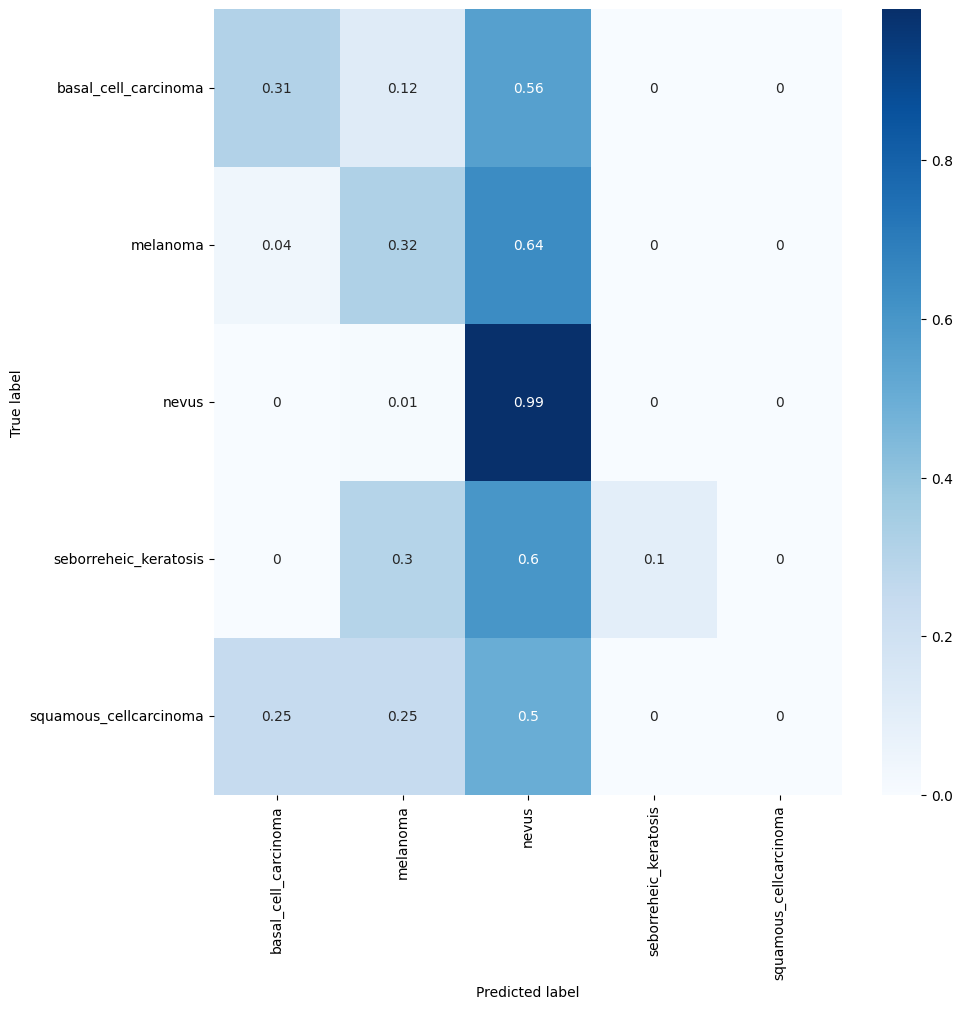

In [19]:
figure = plt.figure(figsize=(10, 10))
sns.heatmap(vgg16_con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [20]:
vgg16_y_pred = vgg16_model.predict(vgg16_test_ds)
vgg16_predicted_categories = np.argmax(vgg16_y_pred, axis = 1)

319/319 [==============================] - 29s 91ms/step


In [21]:
vgg16_true_categories = tf.concat([y for x, y in vgg16_test_ds], axis = 0).numpy() # convert to np array

In [22]:
print(classification_report(vgg16_true_categories, vgg16_predicted_categories))

              precision    recall  f1-score   support

           0       0.60      0.44      0.51      4767
           1       0.59      0.39      0.47      7226
           2       0.81      0.96      0.88     32614
           3       0.37      0.09      0.14      1905
           4       0.34      0.14      0.20      1301

    accuracy                           0.76     47813
   macro avg       0.54      0.40      0.44     47813
weighted avg       0.72      0.76      0.73     47813

